In [3]:
import sys 
import os

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from Matrix_methods.utils import get_frequency_domain
from Matrix_methods.Simulate import simulate_parallel, simulate_reference
from Matrix_methods.BayesianExtractor import BayesianLayeredExtractor
from Matrix_methods.AdamExtractor import LayeredExtractor



print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cpu
CUDA available: False


In [4]:
# TODO:
# Smallest layers
# Cut time domain in half (test incomplete data)
# Num layer limit
# ReTest old experimental with updated code and lr 
#3 layers

In [5]:
def compare_material_stacks(calculated, real):
    """
    Compare two material parameter stacks with separate real/imag errors for n.
    
    Args:
        calculated (list of tuples): [(n_complex, thickness_m), ...]
        real (list of tuples): [(n_complex, thickness_m), ...]
    
    Returns:
        list of dicts with abs and % errors for n_real, n_imag, and thickness.
    """
    results = []
    for i, ((n_calc, d_calc), (n_true, d_true)) in enumerate(zip(calculated, real), start=1):
        
        # Refractive index real part errors
        n_real_abs_err = abs(n_calc.real - n_true.real)
        n_real_pct_err = (n_real_abs_err / abs(n_true.real)) * 100 if n_true.real != 0 else float('inf')
        
        # Refractive index imaginary part errors
        n_imag_abs_err = abs(n_calc.imag - n_true.imag)
        n_imag_pct_err = (n_imag_abs_err / abs(n_true.imag)) * 100 if n_true.imag != 0 else float('inf')

        # Thickness errors
        d_abs_err = abs(d_calc - d_true)
        d_pct_err = (d_abs_err / abs(d_true)) * 100 if d_true != 0 else float('inf')

        results.append({
            "layer": i,
            "n_real_abs_err": n_real_abs_err,
            "n_real_pct_err": n_real_pct_err,
            "n_imag_abs_err": n_imag_abs_err,
            "n_imag_pct_err": n_imag_pct_err,
            "d_abs_err": d_abs_err,
            "d_pct_err": d_pct_err
        })
    
    return results

| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      1.500e-04 |
|            2.522 |        -0.003711 |      1.790e-04 |
|            5.411 |        -0.005331 |      1.020e-04 |
|            4.213 |        -0.008436 |      2.060e-04 |
|            1.660 |        -0.009043 |      1.200e-04 |
(Negative absorption coeff means loss in the material.)

Total Thickness: 757.0 µm


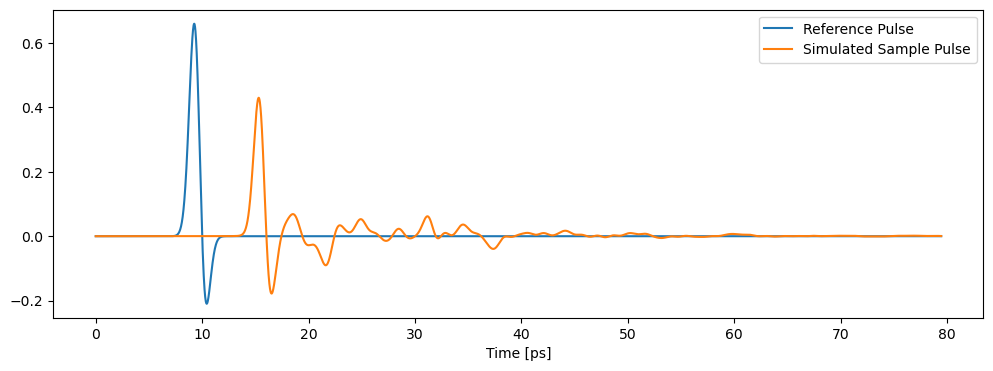

In [6]:
# Define simulation parameters
deltat = 0.0194e-12  # Time step
L = 2**12  # Number of time points

# Generate reference pulse
reference_pulse = simulate_reference(L, deltat)

n_values = [3.364, 2.522, 5.411, 4.213, 1.66]
k_values = [-0.000356, -0.003711, -0.005331, -0.008436, -0.009043]
d_values = [150e-06, 179e-6, 102e-6, 206e-6, 120e-06]

# Experimental material parameters (ground truth)
material_params_exp = [[(n_values[i] + 1j * k_values[i]), d_values[i]] for i in range(len(n_values))]


# Simulate the experimental data
t_axis = np.arange(0, L * deltat, deltat)
T_exp, experimental_pulse = simulate_parallel(reference_pulse, material_params_exp, deltat, noise_level=0)
experimental_pulse = experimental_pulse[:L]


print("| Refractive Index | Absorption Coeff | Thickness [µm] |")
print("|------------------|------------------|----------------|")

for item in material_params_exp:
    n_real = np.real(item[0])
    n_imag = np.imag(item[0])
    thickness = item[1]
    print(f"| {n_real:16.3f} | {n_imag:16.6f} | {thickness:14.3e} |")

print('(Negative absorption coeff means loss in the material.)')

print(f'\nTotal Thickness: {sum(d_values) * 1e6} µm')

plt.figure(figsize=(12,4))
#plt.title(f'Simulated Time Domain of THz Pulse Passing Through a {len(n_values)} Layered Sample')
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse')
#plt.scatter(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), s=2, color= 'orange', label='Simulated Sample Pulse')
plt.xlabel('Time [ps]')
plt.legend()
plt.show()

N: 4096 frequency points


C:\Users\theod\AppData\Local\Temp\ipykernel_1524\1895586919.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.plot(freqs_ref[:N//2]*1e-12, np.real(np.log10(spectrum_ref[:N//2].detach().cpu().numpy())), label='Reference Pulse')


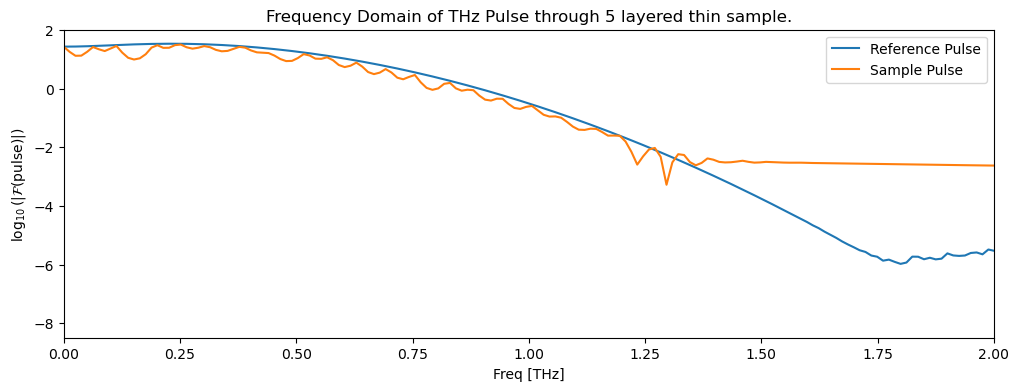

In [7]:
# Convert to frequency
freqs_ref, spectrum_ref = get_frequency_domain(reference_pulse, deltat=deltat)
freqs_sample, spectrum_sample = get_frequency_domain(experimental_pulse, deltat=deltat)

N = len(freqs_ref)
print(f'N: {N} frequency points')

plt.figure(figsize=(12,4))
plt.title('Frequency Domain of THz Pulse through 5 layered thin sample.')
plt.plot(freqs_ref[:N//2]*1e-12, np.real(np.log10(spectrum_ref[:N//2].detach().cpu().numpy())), label='Reference Pulse')
plt.plot(freqs_sample[:N//2]*1e-12, np.real(np.log10(spectrum_sample[:N//2].detach().cpu().numpy())), label='Sample Pulse')
plt.ylabel(r'$\log_{10}(|\mathcal{F}(\mathrm{pulse})|)$')
plt.xlabel('Freq [THz]')
plt.xlim(0, 2)  
plt.legend()
plt.show()

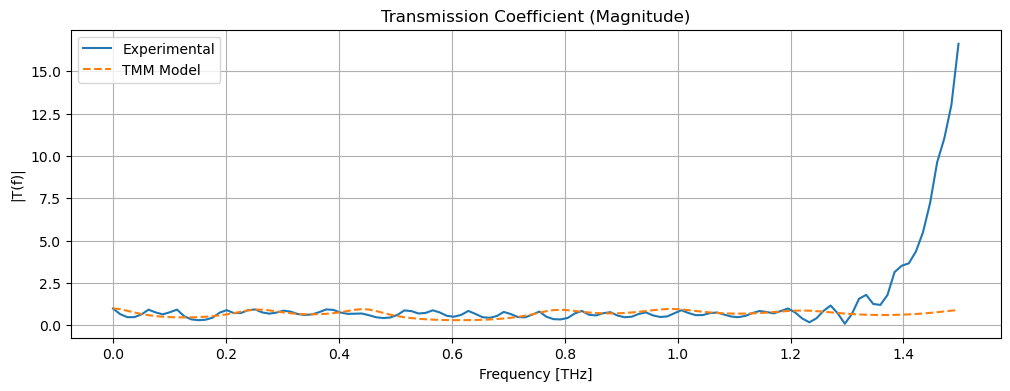

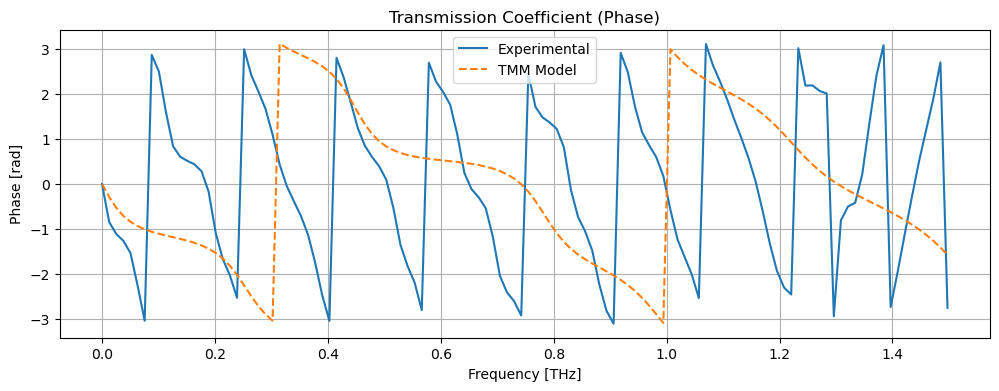

In [8]:
# --- Experimental transmission from data ---
freqs_ref, spec_ref = get_frequency_domain(reference_pulse, deltat)
_, spec_samp = get_frequency_domain(experimental_pulse, deltat)
T_exp = spec_samp / spec_ref  # Experimental transfer function

# --- Model transmission from TMM ---
T_model_full, _ = simulate_parallel(reference_pulse, material_params_exp, deltat)
# Downsample to same frequency resolution as experimental FFT
L = len(reference_pulse)
T_model = T_model_full[:L]  # Match positive + negative frequencies in exp data

# --- Frequency mask for 0–4 THz ---
freqs_thz = freqs_ref[:L//2] * 1e-12
mask = freqs_thz <= 1.5

# --- Plot magnitude ---
plt.figure(figsize=(12,4))
plt.title("Transmission Coefficient (Magnitude)")
plt.plot(freqs_thz[mask], np.abs(T_exp[:L//2][mask].detach().numpy()), label="Experimental")
plt.plot(freqs_thz[mask], np.abs(T_model[:L//2][mask].detach().numpy()), label="TMM Model", linestyle="--")
plt.xlabel("Frequency [THz]")
plt.ylabel("|T(f)|")
plt.legend()
plt.grid(True)
plt.show()

# --- Plot phase ---
plt.figure(figsize=(12,4))
plt.title("Transmission Coefficient (Phase)")
plt.plot(freqs_thz[mask], np.angle(T_exp[:L//2][mask].detach().numpy()), label="Experimental")
plt.plot(freqs_thz[mask], np.angle(T_model[:L//2][mask].detach().numpy()), label="TMM Model", linestyle="--")
plt.xlabel("Frequency [THz]")
plt.ylabel("Phase [rad]")
plt.legend()
plt.grid(True)
plt.show()

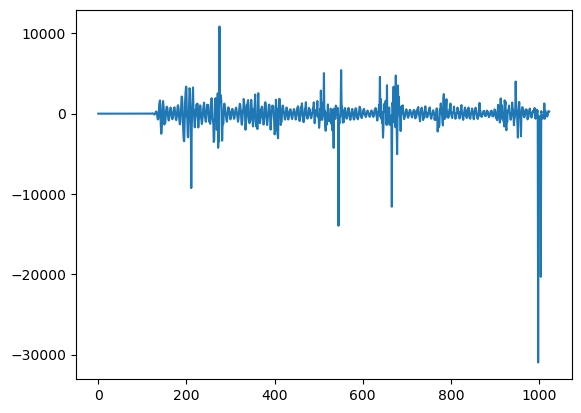

In [9]:
plt.plot(np.real(T_exp.detach().cpu().numpy()[:len(T_exp)//4]))
plt.show()


In [10]:
## Experimental params:

"""
| Refractive Index | Absorption Coeff | Thickness [µm] |
|------------------|------------------|----------------|
|            3.364 |        -0.000356 |      1.500e-04 |
|            2.522 |        -0.003711 |      1.790e-04 |
|            5.411 |        -0.005331 |      1.020e-04 |
|            4.213 |        -0.008436 |      2.060e-04 |
|            1.660 |        -0.009043 |      1.200e-04 |
"""


optimization_bounds = [0.5, 0.01, 50e-6]

n_inits = [3.514, 2.312, 5.611, 4.511, 1.76]
k_inits = [0, 0, 0, 0, 0]
d_inits = [140e-06, 200e-6, 80e-6, 170e-6, 80e-06]
# d real: [150e-06, 179e-6, 102e-6, 206e-6, 120e-06]

layers_init = [[(n_inits[i] + 1j * k_inits[i]), d_inits[i]] for i in range(len(n_inits))]

# Optimize with fixed thickness
optimization_mask = [
    (True, True, True),
    (True, True, True),
    (True, True, True),
    (True, True, True),
    (True, True, True)
]


initial_pulse = simulate_parallel(reference_pulse, layers_init, deltat)[1].detach().cpu().numpy()[:L]

Bayesian_optimizer = BayesianLayeredExtractor(reference_pulse, experimental_pulse, deltat, layers_init, optimize_mask=optimization_mask, optimization_bounds=optimization_bounds)
Bayesian_inits = Bayesian_optimizer.bayesian_optimization(n_calls=250)

Bayesian_pulse = simulate_parallel(reference_pulse, Bayesian_inits, deltat, noise_level=0)[1].detach().cpu().numpy()[:L]

print(Bayesian_inits)
print(material_params_exp)

Starting Bayesian Optimization with masks...
Search Boundaries for Optimized Parameters:
Layer 1 - n ∈ (3.014, 4.013999999999999)
Layer 1 - k ∈ (-0.01, 0.01)
Layer 1 - D ∈ (8.999999999999999e-05, 0.00018999999999999998)
Layer 2 - n ∈ (1.8119999999999998, 2.812)
Layer 2 - k ∈ (-0.01, 0.01)
Layer 2 - D ∈ (0.00015000000000000001, 0.00025)
Layer 3 - n ∈ (5.111, 6.111)
Layer 3 - k ∈ (-0.01, 0.01)
Layer 3 - D ∈ (3.0000000000000004e-05, 0.00013000000000000002)
Layer 4 - n ∈ (4.011, 5.011)
Layer 4 - k ∈ (-0.01, 0.01)
Layer 4 - D ∈ (0.00012000000000000002, 0.00022)
Layer 5 - n ∈ (1.26, 2.26)
Layer 5 - k ∈ (-0.01, 0.01)
Layer 5 - D ∈ (3.0000000000000004e-05, 0.00013000000000000002)


KeyboardInterrupt: 

In [ ]:
init_errors = compare_material_stacks(layers_init, material_params_exp)
for e in init_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.15 (4.46%), n_imag_abs_err=0.000356 (100.00%), d_abs_err=1e-05 (6.67%)
Layer 2: n_real_abs_err=0.21 (8.33%), n_imag_abs_err=0.003711 (100.00%), d_abs_err=2.1e-05 (11.73%)
Layer 3: n_real_abs_err=0.2 (3.70%), n_imag_abs_err=0.005331 (100.00%), d_abs_err=2.2e-05 (21.57%)
Layer 4: n_real_abs_err=0.298 (7.07%), n_imag_abs_err=0.008436 (100.00%), d_abs_err=3.6e-05 (17.48%)
Layer 5: n_real_abs_err=0.1 (6.02%), n_imag_abs_err=0.009043 (100.00%), d_abs_err=4e-05 (33.33%)


In [ ]:
errors = compare_material_stacks(Bayesian_inits, material_params_exp)
for e in errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.35 (10.40%), n_imag_abs_err=0.009644 (2708.99%), d_abs_err=4e-05 (26.67%)
Layer 2: n_real_abs_err=0.71 (28.15%), n_imag_abs_err=0.00353393 (95.23%), d_abs_err=4.17476e-06 (2.33%)
Layer 3: n_real_abs_err=0.7 (12.94%), n_imag_abs_err=0.015331 (287.58%), d_abs_err=2.8e-05 (27.45%)
Layer 4: n_real_abs_err=0.346061 (8.21%), n_imag_abs_err=0.0117753 (139.58%), d_abs_err=6.23573e-05 (30.27%)
Layer 5: n_real_abs_err=0.407045 (24.52%), n_imag_abs_err=0.00960019 (106.16%), d_abs_err=1.58415e-05 (13.20%)


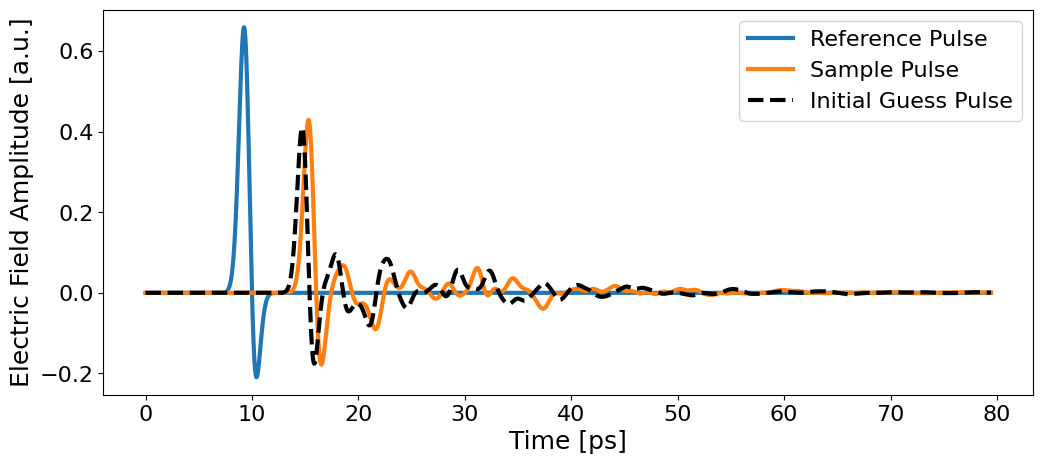

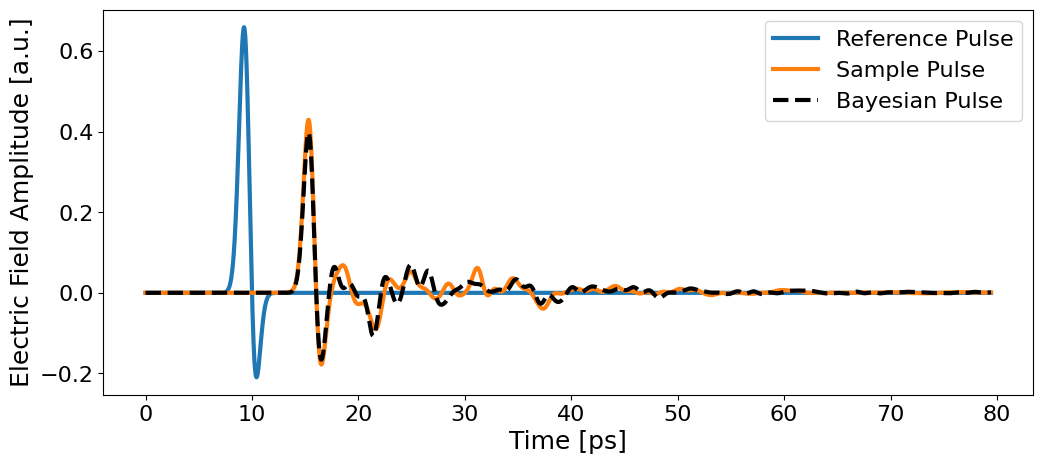

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, initial_pulse, label='Initial Guess Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, Bayesian_pulse, label='Bayesian Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [a.u.]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

Fine-tuning 15 parameters for 2500 iterations.
Iteration 199, Loss: 1.707833e-03, Layer 0: n=3.0259, k=0.03726, D=166.76 µm | Layer 1: n=2.2812, k=-0.01505, D=197.58 µm | Layer 2: n=5.6382, k=-0.02263, D=101.88 µm | Layer 3: n=4.7357, k=-0.01415, D=179.42 µm | Layer 4: n=1.7149, k=-0.00718, D=118.84 µm
Iteration 399, Loss: 9.402867e-04, Layer 0: n=3.1586, k=0.01659, D=158.61 µm | Layer 1: n=2.3822, k=-0.00720, D=190.41 µm | Layer 2: n=5.5390, k=-0.00790, D=101.56 µm | Layer 3: n=4.4972, k=-0.00951, D=190.89 µm | Layer 4: n=1.7168, k=-0.02506, D=115.68 µm
Iteration 599, Loss: 6.618389e-04, Layer 0: n=3.2350, k=0.01111, D=155.27 µm | Layer 1: n=2.4338, k=-0.00608, D=185.94 µm | Layer 2: n=5.4837, k=-0.00648, D=101.79 µm | Layer 3: n=4.3830, k=-0.00818, D=196.69 µm | Layer 4: n=1.6955, k=-0.01967, D=117.11 µm
Iteration 799, Loss: 5.049822e-04, Layer 0: n=3.2813, k=0.00700, D=153.32 µm | Layer 1: n=2.4654, k=-0.00548, D=183.35 µm | Layer 2: n=5.4550, k=-0.00611, D=101.88 µm | Layer 3: n=4.

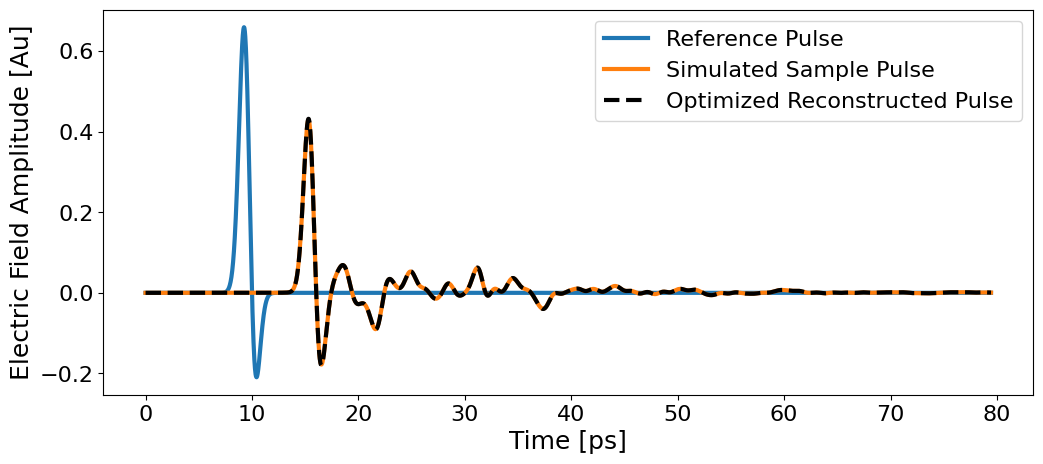

In [ ]:
LE = LayeredExtractor(reference_pulse, experimental_pulse, deltat, Bayesian_inits, lr=0.001, optimize_mask=optimization_mask)
optim_params = LE.optimize(num_iterations=2500, updates=200 , alpha=1)



_, optimal_pulse = simulate_parallel(reference_pulse, optim_params, deltat, noise_level=0)
optimal_pulse = optimal_pulse[:L]

print(optim_params)
plt.figure(figsize=(12,5))
plt.plot(t_axis*1e12, reference_pulse, label='Reference Pulse', linewidth='3')
plt.plot(t_axis*1e12, experimental_pulse.detach().cpu().numpy(), label='Simulated Sample Pulse', linewidth='3')
plt.plot(t_axis*1e12, optimal_pulse.detach().cpu().numpy(), label='Optimized Reconstructed Pulse', color='k', linestyle='--', linewidth='3')
plt.xlabel('Time [ps]', fontsize=18)
plt.ylabel('Electric Field Amplitude [Au]', fontsize=18)
plt.xticks(fontsize=16)  # Increase x-axis tick labels font size
plt.yticks(fontsize=16)  # Increase y-axis tick labels font size
plt.legend(fontsize=16)
plt.show()

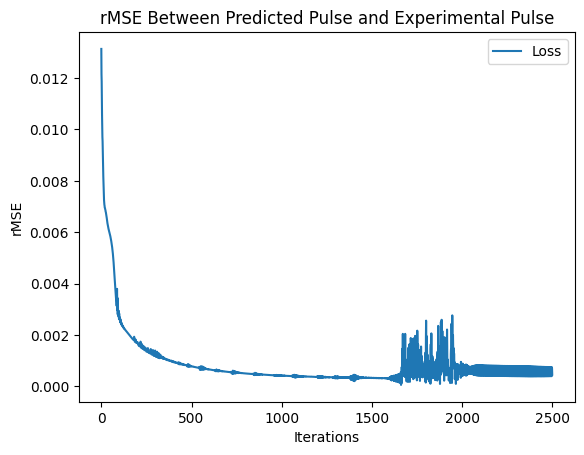

In [ ]:
plt.plot(LE.loss_history, label='Loss')
plt.xlabel("Iterations")
plt.ylabel("rMSE")
plt.title("rMSE Between Predicted Pulse and Experimental Pulse")
plt.legend()
plt.show()

In [ ]:
adam_errors = compare_material_stacks(optim_params, material_params_exp)
for e in adam_errors:
    print(f"Layer {e['layer']}: "
        f"n_real_abs_err={e['n_real_abs_err']:.6g} ({e['n_real_pct_err']:.2f}%), "
        f"n_imag_abs_err={e['n_imag_abs_err']:.6g} ({e['n_imag_pct_err']:.2f}%), "
        f"d_abs_err={e['d_abs_err']:.6g} ({e['d_pct_err']:.2f}%)")

Layer 1: n_real_abs_err=0.0127279 (0.38%), n_imag_abs_err=0.00246749 (693.11%), d_abs_err=5.55614e-07 (0.37%)
Layer 2: n_real_abs_err=0.00856154 (0.34%), n_imag_abs_err=0.000900991 (24.28%), d_abs_err=7.20897e-07 (0.40%)
Layer 3: n_real_abs_err=0.00675513 (0.12%), n_imag_abs_err=0.00116691 (21.89%), d_abs_err=1.40335e-08 (0.01%)
Layer 4: n_real_abs_err=0.0163177 (0.39%), n_imag_abs_err=0.00132553 (15.71%), d_abs_err=8.51698e-07 (0.41%)
Layer 5: n_real_abs_err=0.00385829 (0.23%), n_imag_abs_err=8.75558e-05 (0.97%), d_abs_err=2.82237e-07 (0.24%)


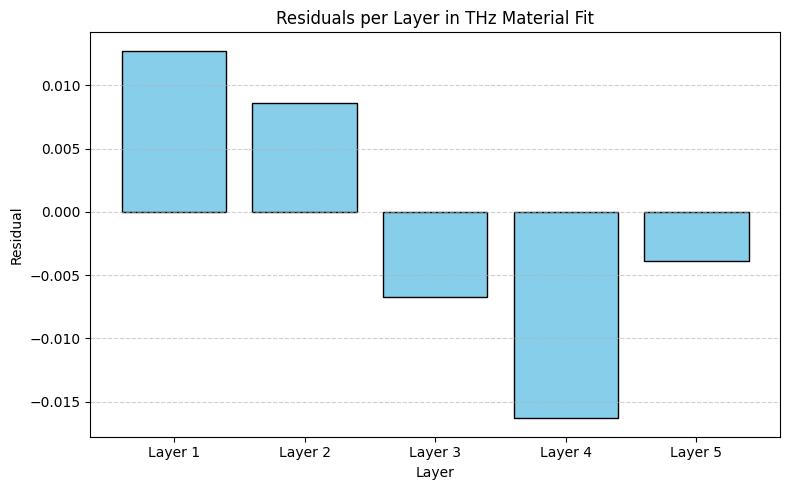

In [ ]:
residuals = [material_params_exp[i][0] - optim_params[i][0] for i in range(len(material_params_exp))]
n_percentage_errors = [(np.real(residuals[i])/np.real(material_params_exp[i][0])) * 100 for i in range(len(residuals))]
k_percentage_errors = [(np.imag(residuals[i])/np.imag(material_params_exp[i][0])) * 100 for i in range(len(residuals))]

# Create bar plot
plt.figure(figsize=(8, 5))
layer_indices = [f"Layer {i+1}" for i in range(len(residuals))]

plt.bar(layer_indices, np.real(residuals), color='skyblue', edgecolor='black')
plt.title("Residuals per Layer in THz Material Fit")
plt.xlabel("Layer")
plt.ylabel("Residual")
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()